In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import scipy.io as sio
import os
import numpy as np

# prepare data into libsvm format

In [8]:
label_path = '../bev/'
feature_path = '../5_MRI2atlas_AAL90_thr/'

labels_mat = sio.loadmat(os.path.join(label_path,'demo.mat'))
print labels_mat.keys()

['demo', '__version__', '__header__', '__globals__']


In [9]:
feature_name_file = '../aal_Conns.txt'
feature_name_list = []
with open(feature_name_file, 'r') as fin:
    feature_name_list = fin.read().split(',')
print len(feature_name_list), feature_name_list[0], type(feature_name_list)

4006 Precentral_L-Precentral_R <type 'list'>


In [10]:
class_labels = [0,1]
feature_names = []

In [11]:
print labels_mat['demo'].shape
print str(labels_mat['demo'][2,0][0])
print labels_mat['demo'][3,2].shape
print labels_mat['demo'][2,2].size
ids_tmp = labels_mat['demo'][1:,0]
labels_tmp = labels_mat['demo'][1:,2]
print ids_tmp.size, labels_tmp.size
print labels_tmp[1].size, ids_tmp[1]

(441, 4)
20071016_02
(1, 1)
0
440 440
0 [u'20071016_02']


## read person id and its label

In [13]:
labels_dict = {}
num_positive = 0
num_negative = 0
for i in range(ids_tmp.size):
    # label of this person is not provided
    if labels_tmp[i].size == 0:
        continue
    label_tmp = 0 if int(labels_tmp[i]) == 2 else 1
    if label_tmp == 0:
        num_negative += 1
    else:
        num_positive += 1
    labels_dict[str(ids_tmp[i][0])] = label_tmp
print("Total:{}, Male:{}, Female:{}".format(num_negative+num_positive, num_positive, num_negative))    

Total:418, Male:179, Female:239


## Read the features

In [14]:
features = []
labels = []
for key in labels_dict:
    if os.path.isfile(os.path.join(feature_path, key+'.mat')):
        # Load feature mat file
        key_mat = sio.loadmat(os.path.join(feature_path, key+'.mat'))
        n,n = key_mat['Wauc'].shape
        # indices for upper matrix items without the diagonal items         
        upper_item_idx = np.triu_indices(n,1)
#         features.append(np.triu(key_mat['Wauc']).flatten().tolist())
        features.append(key_mat['Wauc'][upper_item_idx].tolist())
        labels.append(labels_dict[key])
    else:
        print key, ' is not in ', feature_path
print("n:{}, d:{}".format(len(features), len(features[0])))
        

20080908_04  is not in  ../5_MRI2atlas_AAL90_thr/
20081113_14  is not in  ../5_MRI2atlas_AAL90_thr/
20081128_11  is not in  ../5_MRI2atlas_AAL90_thr/
20080917_02  is not in  ../5_MRI2atlas_AAL90_thr/
20081119_12  is not in  ../5_MRI2atlas_AAL90_thr/
20081107_08  is not in  ../5_MRI2atlas_AAL90_thr/
20081210_13  is not in  ../5_MRI2atlas_AAL90_thr/
20081203_11  is not in  ../5_MRI2atlas_AAL90_thr/
20081118_04  is not in  ../5_MRI2atlas_AAL90_thr/
20081110_09  is not in  ../5_MRI2atlas_AAL90_thr/
20081114_08  is not in  ../5_MRI2atlas_AAL90_thr/
20081210_07  is not in  ../5_MRI2atlas_AAL90_thr/
20081126_02  is not in  ../5_MRI2atlas_AAL90_thr/
20080613_05  is not in  ../5_MRI2atlas_AAL90_thr/
20080613_06  is not in  ../5_MRI2atlas_AAL90_thr/
20081127_12  is not in  ../5_MRI2atlas_AAL90_thr/
n:402, d:4005


In [15]:
def print_top_features(clf, top_k=10):
    """Prints features with the highest coefficient values, per class"""
#     feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        print clf.coef_
        top_features_idx = np.argsort(clf.coef_[i])[-top_k:]
        if feature_names == []:
            print("{}:{}".format(class_label, top_features_idx))
        else:
            print("%s: %s" % (class_label,
                  " ".join(feature_names[j] for j in top_features_idx)))

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [17]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [18]:
# iterate over classifiers
for name, clf in zip(names, classifiers):
    scores = cross_val_score(clf, features, labels, cv=5)
#     if hasattr(clf, 'coef_'):
    print("{}, {}/{}".format(name, np.mean(scores), np.std(scores)))
#     if name not in ["Nearest Neighbors",  "Linear SVM", "RBF SVM","Gaussian Process", "Neural Net"]:
#         print_top_features(clf)

Nearest Neighbors, 0.582137834037/0.0521829368399
Linear SVM, 0.582103844351/0.00281046506521
RBF SVM, 0.594511251758/0.0125627312552
Gaussian Process, 0.582103844351/0.00281046506521
Decision Tree, 0.602231208001/0.0312159473933
Random Forest, 0.562289810908/0.030153034214
Neural Net, 0.594479606188/0.0293381954356
AdaBoost, 0.647172605095/0.0484604475855
Naive Bayes, 0.569350679794/0.0594274344346

/Library/Python/2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Library/Python/2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



QDA, 0.494658540397/0.0719858950252


In [19]:
print 'feature max: ', np.max(features), ' min: ', np.min(features)

feature max:  0.292096591372  min:  0.0


In [22]:
def plot_important_features(features, clf, num_selected_features=50):
    importances = adaboost_clf.feature_importances_
    X = np.array(features)
    std = np.std([tree.feature_importances_ for tree in adaboost_clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(0,num_selected_features):
        print("%d. feature %s (%f)" % (f + 1, feature_name_list[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(num_selected_features), importances[indices[:num_selected_features]],
           color="r", yerr=std[indices[:num_selected_features]], align="center")
    plt.xticks(range(num_selected_features), indices[:num_selected_features])
    plt.xlim([-1, num_selected_features])
    plt.show()

Feature ranking:
1. feature Pallidum_L-Thalamus_L (0.060000)
2. feature Cingulum_Ant_L-Lingual_R (0.020000)
3. feature Frontal_Inf_Orb_L-Occipital_Inf_L (0.020000)
4. feature Hippocampus_R-Putamen_R (0.020000)
5. feature Thalamus_L-Thalamus_R (0.020000)
6. feature Hippocampus_R-Pallidum_L (0.020000)
7. feature Cingulum_Mid_R-ParaHippocampal_R (0.020000)
8. feature Lingual_L-Occipital_Sup_R (0.020000)
9. feature Frontal_Inf_Oper_L-Temporal_Inf_L (0.020000)
10. feature Amygdala_R-Fusiform_L (0.020000)
11. feature Lingual_L-Precuneus_R (0.020000)
12. feature Frontal_Inf_Orb_L-Parietal_Sup_L (0.020000)
13. feature Fusiform_R-Angular_R (0.020000)
14. feature Fusiform_R-Temporal_Sup_L (0.020000)
15. feature Occipital_Sup_R-Paracentral_Lobule_L (0.020000)
16. feature Calcarine_R-Postcentral_L (0.020000)
17. feature Precentral_L-Calcarine_L (0.020000)
18. feature Precuneus_R-Thalamus_R (0.020000)
19. feature Insula_L-Temporal_Sup_R (0.020000)
20. feature Occipital_Sup_L-SupraMarginal_L (0.0200

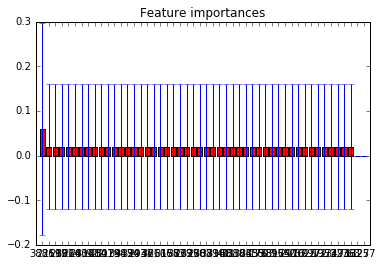

In [23]:

adaboost_clf = AdaBoostClassifier()
adaboost_clf.fit(features, labels)
plot_important_features(features, adaboost_clf, 50)

## scale the feature and evaluate the performance of each classifier

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# iterate over classifiers
for name, clf in zip(names, classifiers):
    scores = cross_val_score((make_pipeline(StandardScaler(), clf)), features, labels, cv=5)
    print("{}, {}/{}".format(name, np.mean(scores), np.std(scores)))
#     if name not in ["Nearest Neighbors"]:
#         print_top_features(clf)

Nearest Neighbors, 0.584447179247/0.0325339017845
Linear SVM, 0.601730348492/0.0562679508493
RBF SVM, 0.582103844351/0.00281046506521
Gaussian Process, 0.582103844351/0.00281046506521
Decision Tree, 0.6765537584/0.0755054855802
Random Forest, 0.594387013596/0.0342698579048
Neural Net, 0.61879590561/0.0677481905554
AdaBoost, 0.71127519925/0.0325469042521
Naive Bayes, 0.529379199875/0.057575945213
QDA, 0.499968745116/0.0123614546275


Feature ranking:
1. feature Pallidum_L-Thalamus_L (0.060000)
2. feature Cingulum_Ant_L-Lingual_R (0.020000)
3. feature Frontal_Inf_Orb_L-Occipital_Inf_L (0.020000)
4. feature Hippocampus_R-Putamen_R (0.020000)
5. feature Thalamus_L-Thalamus_R (0.020000)
6. feature Hippocampus_R-Pallidum_L (0.020000)
7. feature Cingulum_Mid_R-ParaHippocampal_R (0.020000)
8. feature Lingual_L-Occipital_Sup_R (0.020000)
9. feature Frontal_Inf_Oper_L-Temporal_Inf_L (0.020000)
10. feature Amygdala_R-Fusiform_L (0.020000)
11. feature Lingual_L-Precuneus_R (0.020000)
12. feature Frontal_Inf_Orb_L-Parietal_Sup_L (0.020000)
13. feature Fusiform_R-Angular_R (0.020000)
14. feature Fusiform_R-Temporal_Sup_L (0.020000)
15. feature Occipital_Sup_R-Paracentral_Lobule_L (0.020000)
16. feature Calcarine_R-Postcentral_L (0.020000)
17. feature Precentral_L-Calcarine_L (0.020000)
18. feature Precuneus_R-Thalamus_R (0.020000)
19. feature Insula_L-Temporal_Sup_R (0.020000)
20. feature Occipital_Sup_L-SupraMarginal_L (0.0200

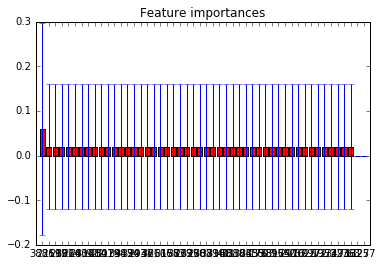

In [25]:
scaled_adaboost_clf = make_pipeline(StandardScaler(), AdaBoostClassifier())
scaled_adaboost_clf.fit(features, labels)
plot_important_features(features, scaled_adaboost_clf)